In [ ]:
#Oh damn you actually click! Hehe Enjoy I guess :D. If you want to save the Jupyter Notebook, click the save to drive right above this comment!

In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 5.4MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.vision.all import *
from fastai.vision.gan import *

In [ ]:
path = untar_data(URLs.IMAGEWANG_320)

In [ ]:
path.ls()

(#3) [Path('/root/.fastai/data/imagewang-320/unsup'),Path('/root/.fastai/data/imagewang-320/train'),Path('/root/.fastai/data/imagewang-320/val')]

In [ ]:
(path/'unsup').ls()

(#7750) [Path('/root/.fastai/data/imagewang-320/unsup/n02087394_24614.JPEG'),Path('/root/.fastai/data/imagewang-320/unsup/n02115641_6633.JPEG'),Path('/root/.fastai/data/imagewang-320/unsup/n02099601_8116.JPEG'),Path('/root/.fastai/data/imagewang-320/unsup/ILSVRC2012_val_00035414.JPEG'),Path('/root/.fastai/data/imagewang-320/unsup/n02086240_6363.JPEG'),Path('/root/.fastai/data/imagewang-320/unsup/n02093754_2788.JPEG'),Path('/root/.fastai/data/imagewang-320/unsup/ILSVRC2012_val_00027025.JPEG'),Path('/root/.fastai/data/imagewang-320/unsup/n02093754_35.JPEG'),Path('/root/.fastai/data/imagewang-320/unsup/n02093754_1368.JPEG'),Path('/root/.fastai/data/imagewang-320/unsup/n02087394_2498.JPEG')...]

In [ ]:
path_hr = path/'unsup'
path_lr = path/'crappy'

In [ ]:
def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

In [ ]:
class Crappifier():
  def __init__(self, path_lr, path_hr):
      self.path_lr = path_lr
      self.path_hr = path_hr              
  def __call__(self, fn):    
      dest = self.path_lr/fn.relative_to(self.path_hr)  
      dest.parent.mkdir(parents=True, exist_ok=True)
      img = Image.open(fn).convert("LA")
      targ_sz = resize_to(img, 150, use_min=True)
      img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
      # w,h = img.size
      img.save(dest)

In [ ]:
items = get_image_files(path_hr)

In [ ]:
parallel(Crappifier(path_lr, path_hr), items);

In [ ]:
bad_im = get_image_files(path_lr)

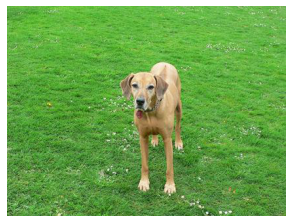

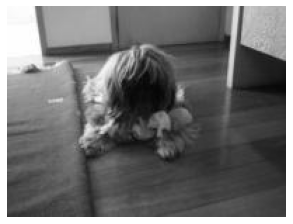

In [ ]:
im1 = PILImage.create(items[9])
im2 = PILImage.create(bad_im[10])
im1.show(figsize = (5,5)); im2.show(figsize = (5,5))

# DataBlock

In [ ]:
#Define a function that returns file path to the high resolution image (you pass in the low res image take out the name and shove it at the end of the path)
def get_y(x): return path_hr/x.name

In [ ]:
#Creates a dataloader that can take in the batch size and size of image
def get_dls(bs:int, size:int):
  #Define a datablock first which can changes the size
  dblock = DataBlock(
    #Image to image block
    blocks = (ImageBlock, ImageBlock),
    #Can grab all the file names of the images (to feed them)
    get_items = get_image_files,
    #Grabs the high resolution image as the y
    get_y = get_y,
    #Split it randomly
    splitter = RandomSplitter(),
    #Item transform that resizes
    item_tfms = Resize(size),
    #Barch transform that does your regular augment transforms which has a max zoom of 2 plus normalize from imagenet 
    batch_tfms = [*aug_transforms(max_zoom = 2.),
                  Normalize.from_stats(*imagenet_stats)])
  #Dataloder which takes in the low res as independent, batch size, and sets the general path
  dls = dblock.dataloaders(path_lr, bs=bs, path = path)
  #Number of channels = 3
  dls.c = 3
  #Returns it out
  return dls

# Pre-Trained Generator

In [ ]:
#Dataloaders for the generator
dls_gen = get_dls(32, 128)

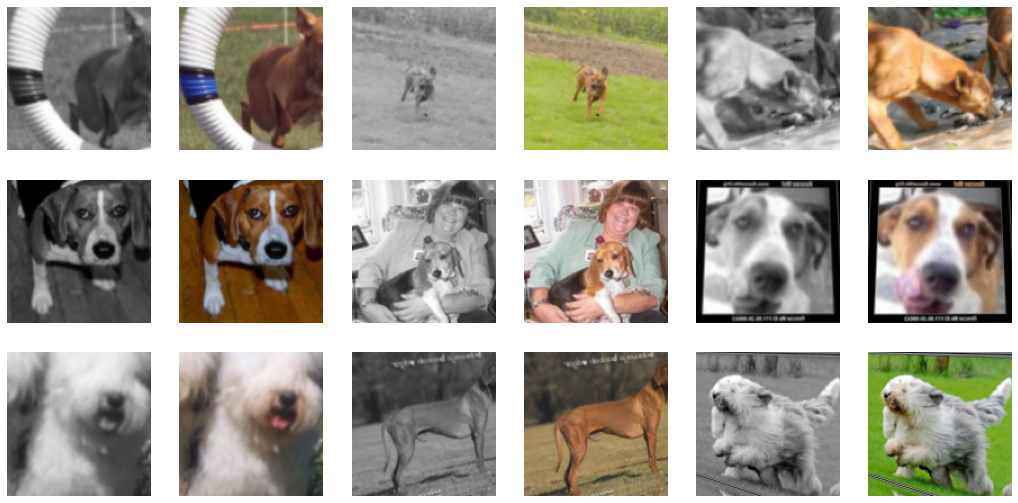

In [ ]:
#Show batch
dls_gen.show_batch()

In [ ]:
#Set up some Hyper parameters
wd = 1e-3
y_range = (-3., 3.)
loss_gen = MSELossFlat()

In [ ]:
#Setting model
bbone = resnet34
#Create a config, which will create a unet for us... Idk about the parameters
cfg = unet_config(blur = True, norm_type = NormType.Weight, self_attention = True, y_range = y_range)

In [ ]:
#A function that creates a GEN learner
def create_gen_learner():
  #returns a unit, passing in the dls, model, loss, and config
  return unet_learner(dls_gen, bbone, loss_func = loss_gen,
                      config = cfg)

In [ ]:
#Creates the generator learner
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
#Train
learn_gen.fit_one_cycle(2, pct_start = 0.8, wd = wd)

epoch,train_loss,valid_loss,time
0,0.125479,0.117563,01:26
1,0.102648,0.099823,01:21


In [ ]:
#Unfreeze and train
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3), wd = wd)

epoch,train_loss,valid_loss,time
0,0.101483,0.104916,01:27
1,0.095230,0.094667,01:26
2,0.088998,0.091523,01:26


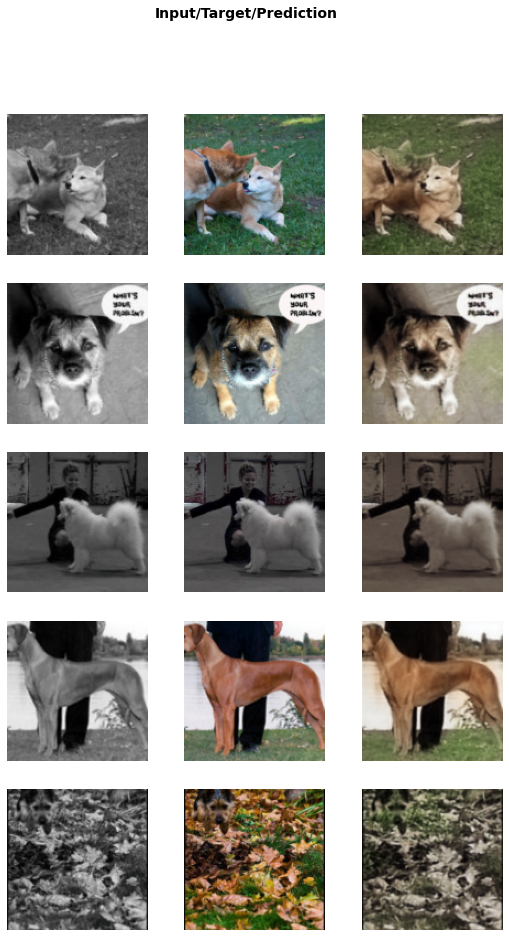

In [ ]:
#Show results
learn_gen.show_results()

In [ ]:
#Save it
learn_gen.save('gen-pre2')

Path('/root/.fastai/data/imagewang-320/models/gen-pre2.pth')

# Save generated Images

In [ ]:
#Create a fonder named image_gen and it'll be contained in the path
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
#Create the folder
path_gen.mkdir(exist_ok=True)

In [ ]:
#Create a function that takes in the dataloader and learner and saves the predictions (images)
def save_preds(dl, learn):
  #Grabs all the file names
  names = dl.dataset.items
  #Get the predicted images
  preds, _ = learn.get_preds(dl = dl)
  #
  for i, pred in enumerate(preds):
    #Takes the predicted image (which is normalize) and unnormalizes it such that it's back to 0-255
    dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
    #Takes the array and transposes it
    arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
    #Shoves the image that was in the form of an array to the path of generated images with the name attached
    Image.fromarray(arr).save(path_gen/names[i].name)

In [ ]:
#Creating a new dl from the old dataloaders (from the training data) [No shuffle, don't droplast, and don't do any augmentation]
dl = dls_gen.train.new(shuffle=False, drop_last=False, 
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
save_preds(dl, learn_gen)

# Training the Critic

In [ ]:
#Getting all the file names of the generated images and the original images
path_g = get_image_files(path/name_gen)
path_i = get_image_files(path/'images')
fnames = path_g + path_i

In [ ]:
#Function to create dataloaders for us
def get_crit_dls(fnames, bs:int, size:int):
  #10% of it is going to the validation set and we're splitting the fnames
  splits = RandomSplitter(0.1)(fnames)
  #for each image we add in some details: Type of image (RGB), the size of the image, and whether or not it's a generated or a high definition image
  dsrc = Datasets(fnames, tfms = [[PILImage.create], [parent_label, Categorize]], splits = splits)
  #Define the transforms: turn to tensor and resize to size
  tfms = [ToTensor(), Resize(size)]
  #transforms udner GPU: Convert ints to floats in tensors and normalize
  gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
  #Return the id dataset (dsrc) and shove it as a dataloader with the bs, item_tfms, gpu_tfms
  return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

In [ ]:
#Create the critic dataloader
dls_crit = get_crit_dls(fnames, bs = 32, size = 128)

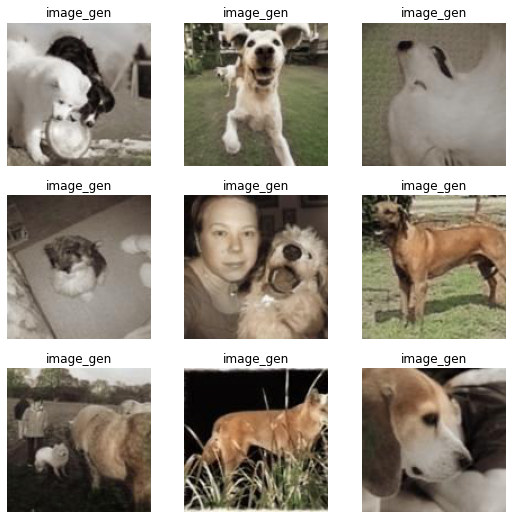

In [ ]:
#Shows the batch
dls_crit.show_batch()

In [ ]:
#Set the loss function
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
#Function to define a basic learner given dataloaders and metrics
def create_crit_learner(dls, metrics):
  return Learner(dls, gan_critic(), metrics = metrics, loss_func = loss_crit)

In [ ]:
#Define a learner
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

In [ ]:
#Fit it
learn_crit.fit_one_cycle(3, 1e-3, wd = wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.001064,0.000000,1.000000,01:42
1,0.000031,0.000000,1.000000,01:37
2,0.000001,0.000000,1.000000,01:37


In [ ]:
#Save it
learn_crit.save('critic-pre2')

Path('models/critic-pre2.pth')

# GAN

In [ ]:
#Create the dataloaders for the critic (differetn bs and size)
dls_crit = get_crit_dls(fnames, bs = 32, size = 128)

In [ ]:
#Create the learner for the crit... Load in the old one
learn_crit = create_crit_learner(dls_crit, metrics = None).load('critic-pre2')

In [ ]:
#Load in the learn generator
learn_gen = create_gen_learner().load('gen-pre2')

In [ ]:
#Class that's creating GANs with discriminative learning rates
class GANDiscriminativeLR(Callback):
  #Initialization = set up the learning rate
  def __init__(self, mult_lr = 5.): self.mult_lr = mult_lr

  #multiplies the current lr if necessary
  def begin_batch(self):
    #If it's not in the generative mode and it's training then do the lr
    if not self.learn.gan_trainer.gen_mode and self.training:
      self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)
  
  #Turn the lr back to it's orignal value
  def after_batch(self):
    #If it's not in the generative mode then redo the lr
    if not self.learn.gan_trainer.gen_mode: 
      self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [ ]:
#When the threshold of the critic loss gets under 0.65, switch it to the other guy... When it goes back up we redo the critic 
switcher = AdaptiveGANSwitcher(critic_thresh = .65)

In [ ]:
#Define the GAN... Passing in the learn generator, learn critic, weights, switcher, optimizer and the call back of switching the LR
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen = (1., 50.), show_img = True, switcher = switcher,
                                 opt_func = partial(Adam, mom=0), cbs = GANDiscriminativeLR(mult_lr=5.))

In [ ]:
#Define LR
lr = 1e-4

In [ ]:
learn.fit(15, lr, wd = wd)

epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,0.689868,5.276842,5.276842,0.692219,04:16
1,0.691533,5.276842,5.276842,0.690877,04:14
2,0.692012,5.276842,5.276842,0.687748,04:14
3,0.692684,5.276842,5.276842,0.688904,04:14
4,0.691730,5.276842,5.276842,0.688372,04:13
5,0.691176,5.276842,5.276842,0.689843,04:13
6,0.691822,5.276842,5.276842,0.688986,04:13
7,0.692892,5.276842,5.276842,0.688301,04:13
8,0.691874,5.276842,5.276842,0.691118,04:13
9,0.691454,5.276842,5.276842,0.689348,04:13


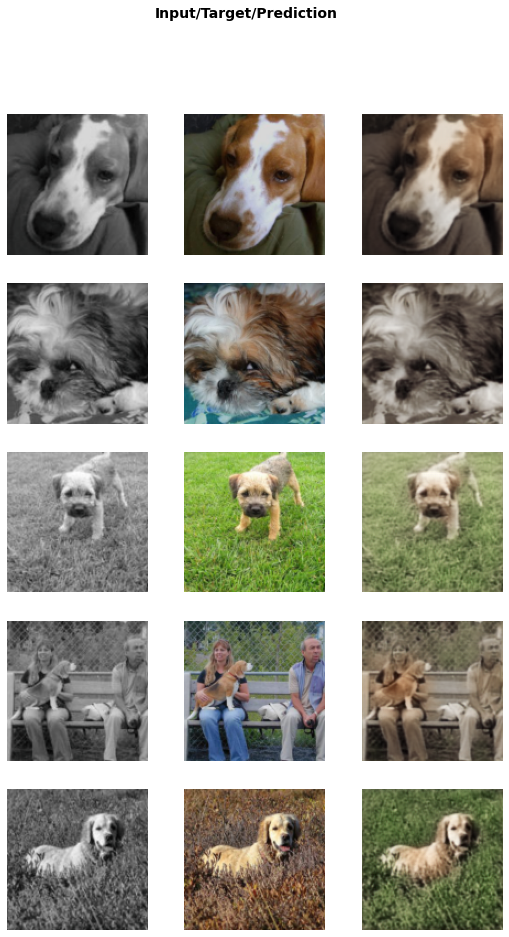

In [ ]:
learn.show_results()

In [ ]:
learn.fit(15, lr, wd = wd)

epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,0.688402,5.277406,5.277406,0.687479,04:15
1,0.692986,5.277406,5.277406,0.688911,04:13
2,0.691133,5.277406,5.277406,0.689043,04:13
3,0.691550,5.277405,5.277405,0.690060,04:13
4,0.691102,5.277405,5.277405,0.688332,04:13
5,0.689985,5.277406,5.277406,0.687697,04:13
6,0.691884,5.277405,5.277405,0.689053,04:13
7,0.690165,5.277406,5.277406,0.689768,04:14
8,0.690103,5.277405,5.277405,0.684198,04:14
9,0.690716,5.277405,5.277405,0.690315,04:13


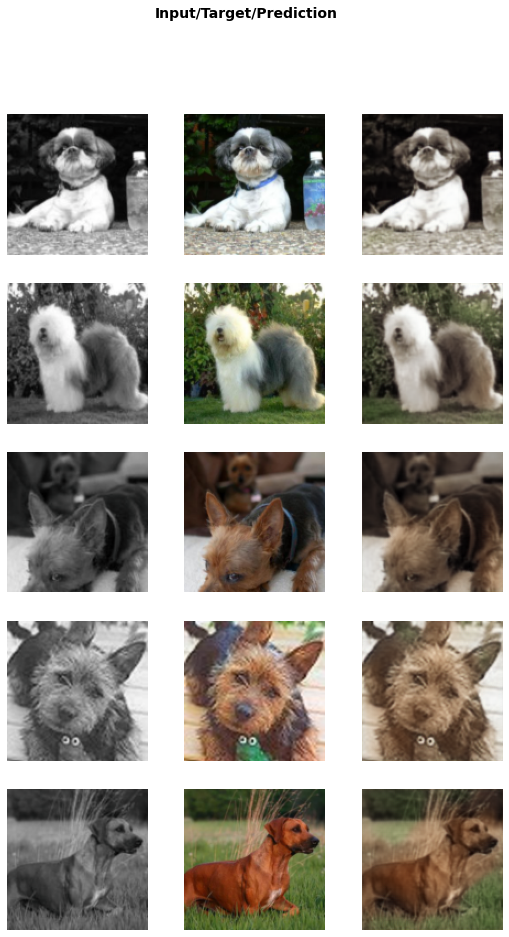

In [ ]:
learn.show_results()

In [ ]:
lr = 1e-3

In [ ]:
learn.fit(15, lr, wd = wd)

epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,0.694338,5.305419,5.305419,0.693133,04:15
1,0.695747,5.305419,5.305419,0.693109,04:14
2,0.696037,5.305419,5.305419,0.694374,04:14
3,0.695357,5.305419,5.305419,0.695460,04:13
4,0.695833,5.305419,5.305419,0.692580,04:13
5,0.695966,5.305419,5.305419,0.693423,04:13
6,0.696164,5.305419,5.305419,0.695749,04:13
7,0.695902,5.305419,5.305419,0.694681,04:13
8,0.696553,5.305419,5.305419,0.694897,04:13
9,0.696213,5.305419,5.305419,0.693430,04:13


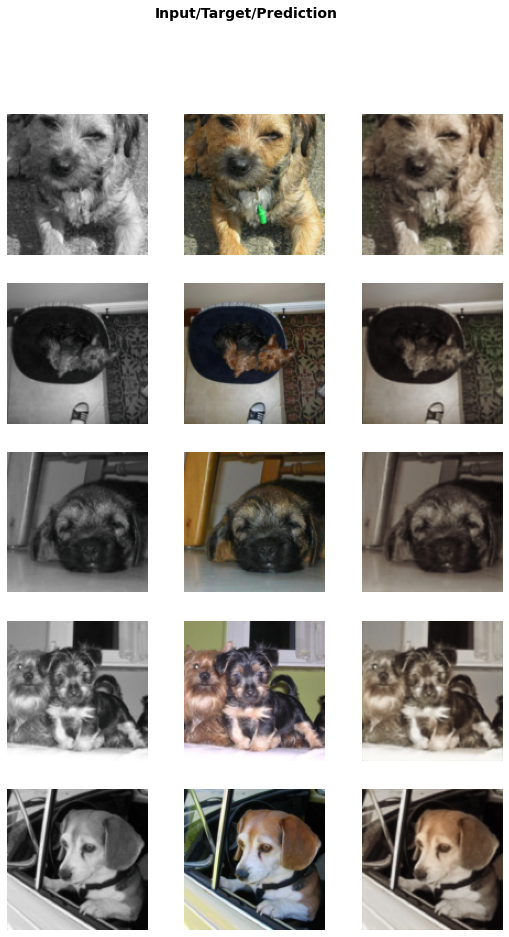

In [ ]:
learn.show_results()